# Heart Disease Classification Pipeline Demo

This notebook demonstrates how to use the ML classification pipeline for the heart disease dataset, both **locally** and on **AWS SageMaker**.

---

## 1. Setup and Data Loading

We'll use the new, disjoint splits: `heart_train.csv`, `heart_val.csv`, and `heart_test.csv`.

In [1]:

import pandas as pd
import numpy as np
# Monkey-patch for SHAP/NumPy compatibility
if not hasattr(np, 'bool'):
    np.bool = np.bool_
if not hasattr(np, 'int'):
    np.int = int
    
train = pd.read_csv('../datasets/heart_train.csv')
val = pd.read_csv('../datasets/heart_val.csv')
test = pd.read_csv('../datasets/heart_test.csv')

print(f'Train shape: {train.shape}')
print(f'Val shape: {val.shape}')
print(f'Test shape: {test.shape}')
train.head()

Train shape: (210, 14)
Val shape: (46, 14)
Test shape: (46, 14)


/var/folders/7z/7gnwr49s6hl4pp9j5dcmgns80000gn/T/ipykernel_82257/1936621746.py:4: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,58,1,0,128,259,0,0,130,1,3.0,1,2,3,0
1,58,1,2,140,211,1,0,165,0,0.0,2,0,2,1
2,51,1,3,125,213,0,0,125,1,1.4,2,1,2,1
3,42,1,2,120,240,1,1,194,0,0.8,0,0,3,1
4,45,1,0,115,260,0,0,185,0,0.0,2,0,2,1


## 2. Local Pipeline Training and Evaluation

We'll use the classic AutoGluon-based pipeline.

**Note:** Make sure you have installed all dependencies from `requirements.txt`.

In [2]:
from classification_pipeline import ClassificationPipeline

pipeline = ClassificationPipeline(output_path='../results/heart_demo')

# Train
pipeline.train(
    train_data=train,
    target_column='target',
    eval_data=val,
    time_limit=60,
    presets='good_quality',
    hyperparameters={'RF': {}}
)

# Evaluate
eval_result = pipeline.evaluate(test, 'target')
print('Test set evaluation:', eval_result['performance'])

# Predict
preds = pipeline.predict(test.drop(columns=['target']))
preds.head()

2025-05-15 15:50:10,119 - INFO - FeatureEngineering: onehot=False, tfidf=False, poly=False
2025-05-15 15:50:10,120 - INFO - Pipeline thresholds: missing=0.75, categorical=15, text=100, onehot=False, tfidf=False, poly=False, shap_class=1
2025-05-15 15:50:10,120 - INFO - [Pipeline] Training started. Train data shape: (210, 14)
2025-05-15 15:50:10,121 - INFO - [Pipeline] Preprocessing started. is_training=True, input shape=(210, 13)
2025-05-15 15:50:10,124 - INFO - Missing data analysis: 0 columns with excessive missingness
2025-05-15 15:50:10,127 - INFO - Feature types: {'categorical_features': ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], 'numeric_features': ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], 'text_features': [], 'date_features': []}
2025-05-15 15:50:10,127 - INFO - [FeatureEngineering] Starting fit_transform. Input shape: (210, 13)
2025-05-15 15:50:10,127 - INFO - [FeatureEngineering] fit_transform complete. Output shape: (210, 13). Time: 0.00s
2025-0

                      model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       RandomForest_BAG_L1   0.879735       0.034581  0.218339                0.034581           0.218339            1       True          1
1       WeightedEnsemble_L2   0.879735       0.034836  0.275576                0.000255           0.057237            2       True          2
2  WeightedEnsemble_L2_FULL        NaN            NaN  0.254722                     NaN           0.057237            2       True          4
3  RandomForest_BAG_L1_FULL        NaN            NaN  0.197485                     NaN           0.197485            1       True          3


PermutationExplainer explainer: 47it [00:37,  1.07s/it]                        
2025-05-15 15:50:48,378 - INFO - [Pipeline] Preprocessing started. is_training=False, input shape=(46, 13)
2025-05-15 15:50:48,379 - INFO - Missing data analysis: 0 columns with excessive missingness
2025-05-15 15:50:48,381 - INFO - Feature types: {'categorical_features': ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], 'numeric_features': ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], 'text_features': [], 'date_features': []}
2025-05-15 15:50:48,381 - INFO - [FeatureEngineering] Starting transform. Input shape: (46, 13)
2025-05-15 15:50:48,382 - INFO - [FeatureEngineering] transform complete. Output shape: (46, 13). Time: 0.00s
2025-05-15 15:50:48,382 - INFO - [Pipeline] Preprocessing complete. Output shape: (46, 13). Time: 0.00s


Test set evaluation: {'roc_auc': 0.9157196969696969, 'accuracy': 0.8913043478260869, 'balanced_accuracy': 0.893939393939394, 'mcc': 0.7901266634534897, 'f1': 0.8936170212765958, 'precision': 0.84, 'recall': 0.9545454545454546}


,0,1,prediction
0,0.010000,0.990000,1
1,0.583333,0.416667,0
2,0.880000,0.120000,0
3,0.410000,0.590000,1
4,0.180000,0.820000,1


## 3. Feature Importance and Explanation

You can access feature importance and partial dependence plots after training.

In [3]:
# Show top features
eval_result['feature_importance'].head()

,feature,importance
0,ca,0.105874
1,thal,0.087128
2,cp,0.081695
3,oldpeak,0.051085
4,slope,0.047030


In [4]:
# Explain a few predictions
explanations = pipeline.explain_prediction(test.drop(columns=['target']).iloc[:3])
explanations['explanations']
explanations

2025-05-15 15:50:48,470 - INFO - [Pipeline] Preprocessing started. is_training=False, input shape=(3, 13)
2025-05-15 15:50:48,473 - INFO - Missing data analysis: 0 columns with excessive missingness
2025-05-15 15:50:48,476 - INFO - Feature types: {'categorical_features': ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], 'numeric_features': ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], 'text_features': [], 'date_features': []}
2025-05-15 15:50:48,477 - INFO - [FeatureEngineering] Starting transform. Input shape: (3, 13)
2025-05-15 15:50:48,480 - INFO - [FeatureEngineering] transform complete. Output shape: (3, 13). Time: 0.00s
2025-05-15 15:50:48,480 - INFO - [Pipeline] Preprocessing complete. Output shape: (3, 13). Time: 0.01s


{'explanations': [{'prediction': 1,
   'shap_values': [0.08333333333333333,
    -0.037037037037037035,
    -0.03703703703703703,
    0.009259259259259259,
    0.0,
    -0.00925925925925926,
    -0.009259259259259259,
    0.06481481481481481,
    0.037037037037037035,
    0.12037037037037039,
    0.15740740740740738,
    0.18518518518518517,
    0.10185185185185186],
   'features': ['age',
    'sex',
    'cp',
    'trestbps',
    'chol',
    'fbs',
    'restecg',
    'thalach',
    'exang',
    'oldpeak',
    'slope',
    'ca',
    'thal']},
  {'prediction': 0,
   'shap_values': [-0.027777777777777776,
    0.037037037037037035,
    0.037037037037037035,
    0.0,
    -0.009259259259259259,
    0.0,
    0.027777777777777776,
    -0.05555555555555555,
    0.018518518518518517,
    -0.06481481481481481,
    -0.10185185185185186,
    -0.06481481481481481,
    -0.12962962962962962],
   'features': ['age',
    'sex',
    'cp',
    'trestbps',
    'chol',
    'fbs',
    'restecg',
    'thalach'

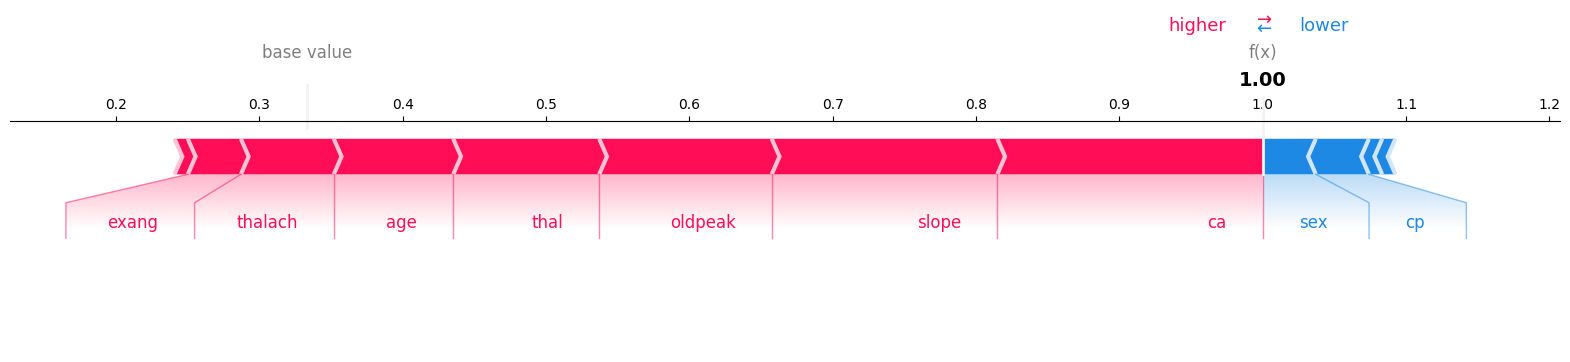

In [5]:
import shap
# Initialize JS for notebook
shap.initjs()

# Get SHAP values and features for the first sample
exp0 = explanations['explanations'][0]
shap_values = np.array(exp0['shap_values'])
features = np.array(exp0['features'])
base_value = explanations['base_value']

# For force_plot, you need a 1D array for shap_values and feature values
# We'll use the processed feature values from the pipeline if available,
# but here we just show the feature names for illustration.
shap.plots.force(base_value, shap_values, features, matplotlib=True)

PermutationExplainer explainer: 47it [00:34,  1.02s/it]                        


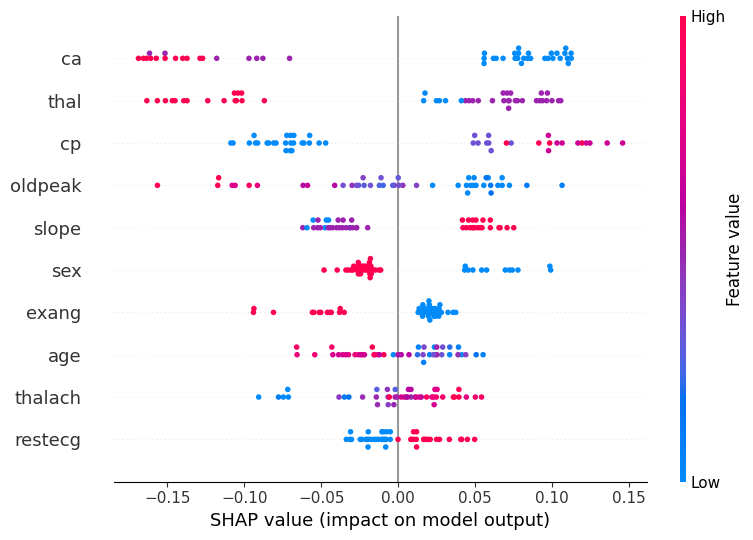

Dependence plot for: ca
Dependence plot for: thal
Dependence plot for: cp


Attempting to set identical low and high xlims makes transformation singular; automatically expanding.


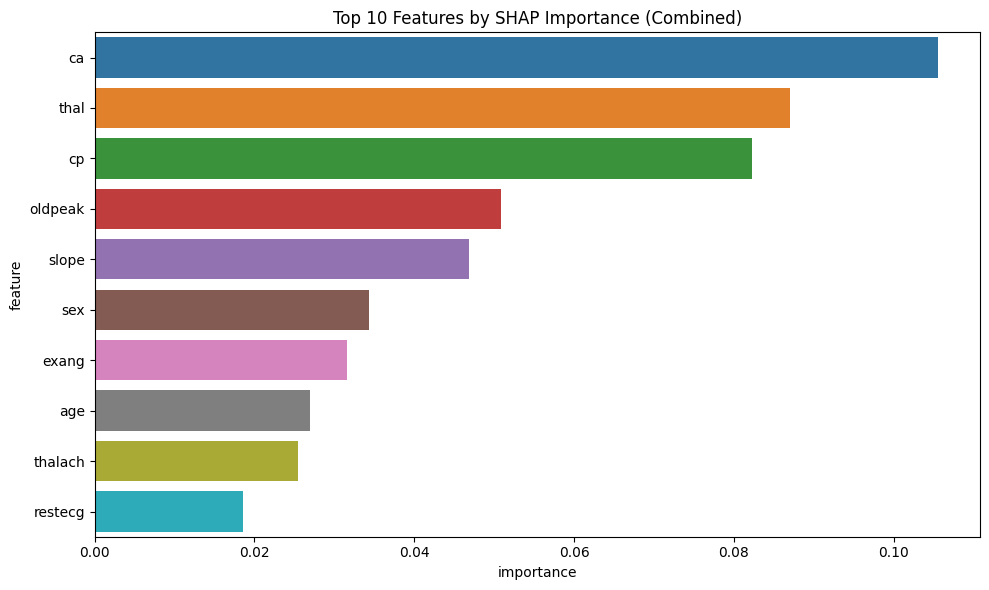

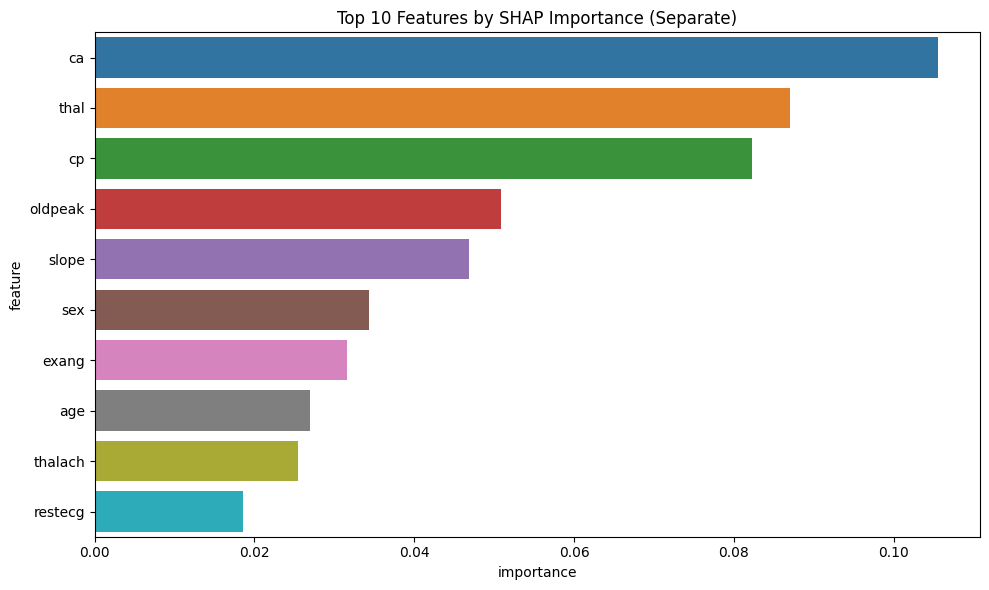

<Figure size 800x600 with 0 Axes>

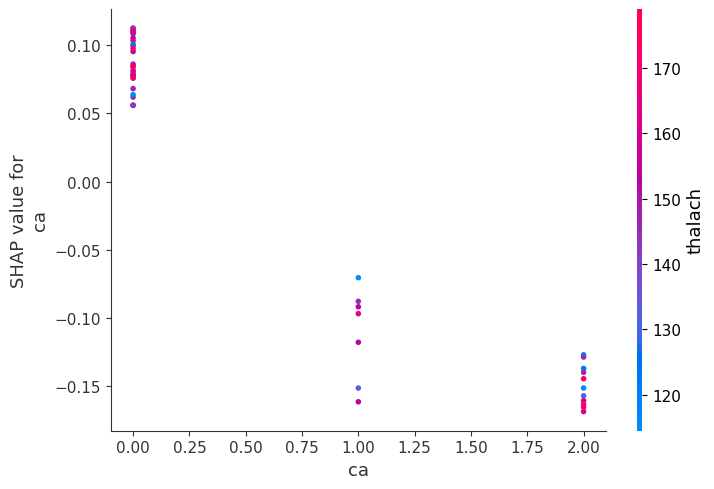

<Figure size 800x600 with 0 Axes>

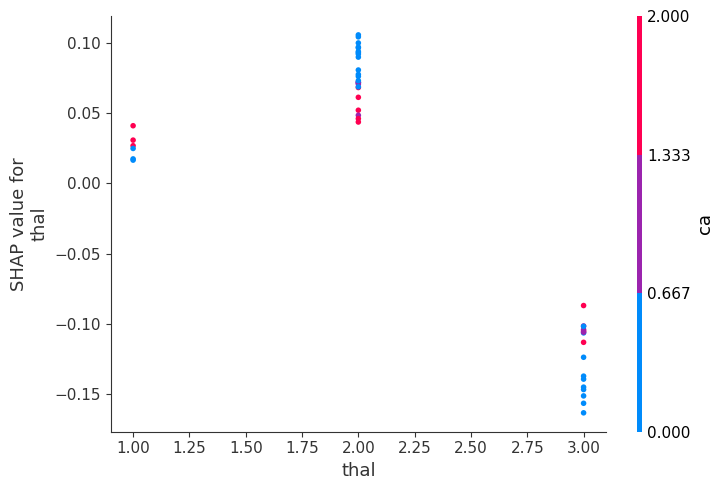

<Figure size 800x600 with 0 Axes>

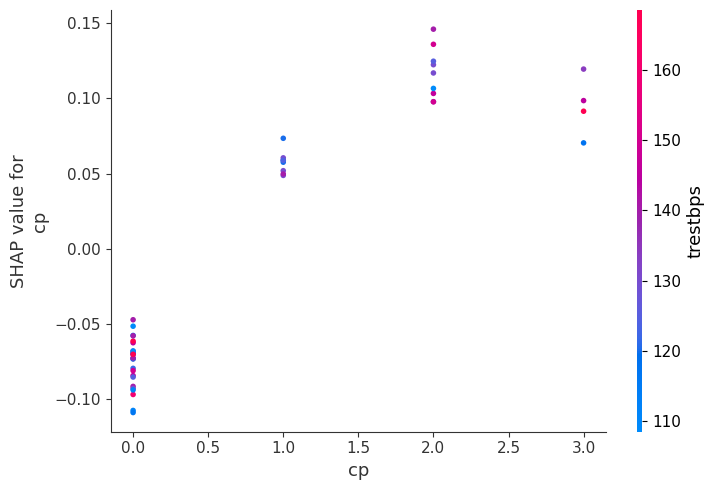

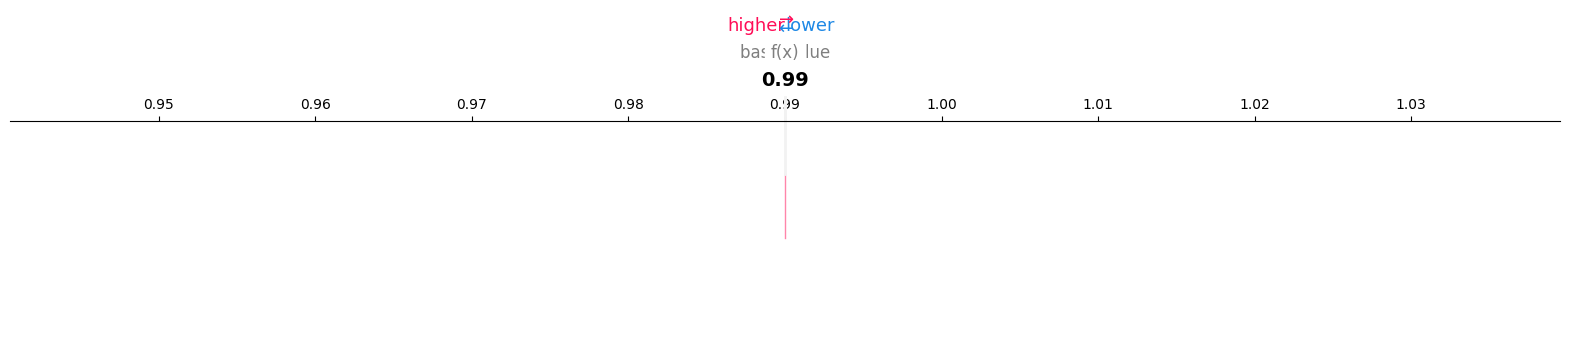

In [6]:
import shap
import numpy as np

# Prepare the feature matrix
X = test.drop(columns=['target'])

# --- SHAP Summary Plot (Global Feature Effects) ---
# Calculate SHAP values for the test set
shap_values = pipeline.feature_importance.calculate_shap_values(X)
shap.summary_plot(shap_values.values, X, max_display=10)

# --- SHAP Bar Plot (Top Features) ---
# SHAP bar plot for top features (combined missing indicators)
pipeline.feature_importance.plot_shap_importance(X, combine_missing=True, max_display=10)

# SHAP bar plot for top features (separate missing indicators)
pipeline.feature_importance.plot_shap_importance(X, combine_missing=False, max_display=10)

# --- SHAP Dependence Plots (Feature Interactions) ---
# Get top 3 features by SHAP importance
top_features = pipeline.feature_importance.get_shap_importance().head(3)['feature']
for feat in top_features:
    print(f"Dependence plot for: {feat}")
    pipeline.feature_importance.plot_shap_dependence(X, feature=feat)

# --- SHAP Force Plot (Local Explanation) ---
shap.initjs()
X_sample = X.iloc[[0]]
shap_values_sample = pipeline.feature_importance.calculate_shap_values(X_sample)
# Try to get expected value(s) robustly
expected = getattr(pipeline.feature_importance.shap_explainer, "expected_value", None)
if expected is None:
    expected = getattr(pipeline.feature_importance.shap_explainer, "expected_values", None)
if isinstance(expected, (list, np.ndarray)) and len(expected) == 2:
    expected = expected[1]  # or 0, depending on which class you want
base_value = getattr(shap_values_sample, "base_values", None)
if base_value is not None:
    base_value = base_value[0]  # For a single sample
else:
    # fallback to expected, but only if not None
    base_value = expected if expected is not None else 0

shap.force_plot(
    base_value,
    shap_values_sample.values[0],
    X_sample.iloc[0],
    matplotlib=True
)



PermutationExplainer explainer: 47it [00:36,  1.07s/it]                        


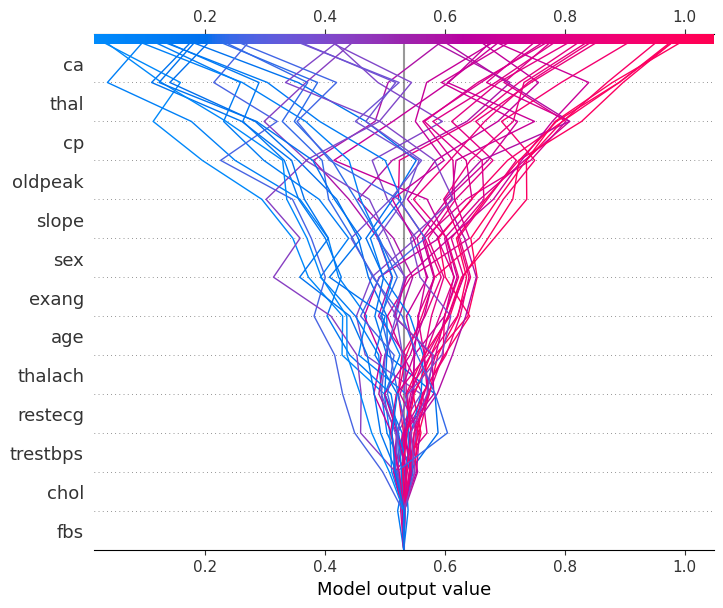

In [7]:
# --- SHAP Decision Plot (Cumulative Feature Effects) ---
# --- SHAP Decision Plot (Cumulative Feature Effects) ---
# --- SHAP Decision Plot (Cumulative Feature Effects) ---
X_samples = X.iloc[:50]
shap_values_samples = pipeline.feature_importance.calculate_shap_values(X_samples)
base_value = getattr(shap_values_samples, "base_values", None)
if base_value is None:
    expected = getattr(pipeline.feature_importance.shap_explainer, "expected_value", None)
    if expected is None:
        expected = getattr(pipeline.feature_importance.shap_explainer, "expected_values", None)
    if isinstance(expected, (list, np.ndarray)) and len(expected) == 2:
        expected = expected[1]
    base_value = expected if expected is not None else 0

# If base_value is an array, use the first value (SHAP expects a scalar for binary classification)
if isinstance(base_value, (list, np.ndarray)) and len(base_value) > 1:
    base_value = base_value[0]

shap.decision_plot(
    base_value,
    shap_values_samples.values,
    X_samples
)

## 4. Preparing for SageMaker Deployment

To deploy on SageMaker, use the provided `sagemaker_deployment.py` script.

- Prepare your config YAML (see `example_config.yaml` or `heart_classic_config.yaml`).
- Upload your data to S3 if running on SageMaker.
- Run the deployment script from the command line.

**Example command:**

```bash
python sagemaker_deployment.py \
  --train-data s3://your-bucket/path/to/heart_train.csv \
  --test-data s3://your-bucket/path/to/heart_test.csv \
  --target-column target \
  --time-limit 3600 \
  --instance-type ml.m5.2xlarge
```

See the [README](../README.md) and [pipeline_usage_guide.md](../pipeline_usage_guide.md) for more details.

---

**Tips:**
- For local runs, you can use local CSV paths in your config.
- For SageMaker, use S3 paths and ensure your IAM permissions are set up.
- You can customize feature engineering, thresholds, and models via the YAML config.

---

_For more, see the repo documentation and guides!_